<a href="https://colab.research.google.com/github/areias/FairFace/blob/master/finetune_distilbert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

here we implement cross entropy loss with class weights



In [1]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change working directory to /content/drive/MyDrive/wb-loan-indicators
%cd  /content/drive/MyDrive/wb-loans-indicators/wb-loan-indicators/

/content/drive/MyDrive/wb-loans-indicators/wb-loan-indicators


In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("data/processed/PforR_PDODLR_database_train_test.csv")

In [5]:
df.dlr_rcp_max_4.value_counts().sort_index() # [0.5419708 , 1.13142857, 2.35714286, 1.18091451])

,count
dlr_rcp_max_4,
(1) S: action,1347
(3) S: intermediate outcome,655
(5) B: output,324
(7) B: outcome,644


In [6]:
df.columns

Index(['id_p', 'id_i', 'p_gp', 'p_approval_fy', 'p_country', 'p_name',
       'p_status', 'i_source', 'i_pdo', 'i_dli', 'i_pdo_only', 'i_prioraction',
       'dli_name', 'dlr_name', 'dlr_value', 'dlr_value_cy', 'appraisal_stage',
       'dlr_rcp_max_6', 'rcp_predict', 'dlr_rcp_max_4', 'combined_text',
       'data_split'],
      dtype='object')

In [7]:
sorted(df['dlr_rcp_max_4'].unique())

['(1) S: action',
 '(3) S: intermediate outcome',
 '(5) B: output',
 '(7) B: outcome']

In [8]:
df.head()

,id_p,id_i,p_gp,p_approval_fy,p_country,p_name,p_status,i_source,i_pdo,i_dli,...,dli_name,dlr_name,dlr_value,dlr_value_cy,appraisal_stage,dlr_rcp_max_6,rcp_predict,dlr_rcp_max_4,combined_text,data_split
0,P116201,116201_0000_0000_410_0_40,URS,2012,Morocco,MA-National Initiative for Human Dev II,C,PDO only (.a),Yes,No,...,% of sampled population in the targeted areas ...,22,NaN,NaN,1.0,(3) S: intermediate outcome,1.0,(3) S: intermediate outcome,% of sampled population in the targeted areas ...,train
1,P116201,116201_0000_0000_420_0_40,URS,2012,Morocco,MA-National Initiative for Human Dev II,C,PDO only (.a),Yes,No,...,% of sampled population in the targeted areas ...,12,NaN,NaN,1.0,(3) S: intermediate outcome,1.0,(3) S: intermediate outcome,% of sampled population in the targeted areas ...,train
2,P116201,116201_0200_0200_200_0_30,URS,2012,Morocco,MA-National Initiative for Human Dev II,C,Both (0),Yes,Yes,...,% population provided with access to improved ...,.72,20.0,usd,1.0,(7) B: outcome,1.0,(7) B: outcome,% population provided with access to improved ...,train
3,P116201,116201_0200_0200_200_0_40,URS,2012,Morocco,MA-National Initiative for Human Dev II,C,Both (0),Yes,Yes,...,% population provided with access to improved ...,.77,20.0,usd,1.0,(7) B: outcome,1.0,(7) B: outcome,% population provided with access to improved ...,train
4,P116201,116201_0300_0300_300_0_30,URS,2012,Morocco,MA-National Initiative for Human Dev II,C,Both (0),Yes,Yes,...,% income-generating activities implemented by ...,.3,20.0,usd,1.0,(6) B: intermediate outcome,1.0,(7) B: outcome,% income-generating activities implemented by ...,train


In [9]:
# create huggingface dataset, wiith combined_text and dlr_rcp_max_4 with train/test split

from datasets import Dataset, DatasetDict
train_df = df[df['data_split'] == 'train']
test_df = df[df['data_split'] == 'test']

In [10]:
# split into train/eval with skelearn

from sklearn.model_selection import train_test_split

train_df, eval_df = train_test_split(train_df, test_size=0.2, random_state=42)


In [11]:
len(train_df), len(eval_df)

(1900, 476)

In [12]:


train_dataset = Dataset.from_pandas(train_df[['combined_text', 'dlr_rcp_max_4']])
eval_dataset = Dataset.from_pandas(test_df[['combined_text', 'dlr_rcp_max_4']])

dataset = DatasetDict({
    'train': train_dataset,
    'eval': eval_dataset
})


In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'dlr_rcp_max_4', '__index_level_0__'],
        num_rows: 1900
    })
    eval: Dataset({
        features: ['combined_text', 'dlr_rcp_max_4', '__index_level_0__'],
        num_rows: 594
    })
})

In [14]:
dataset = dataset.rename_column("dlr_rcp_max_4", "labels")
dataset = dataset.remove_columns("__index_level_0__")

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'labels'],
        num_rows: 1900
    })
    eval: Dataset({
        features: ['combined_text', 'labels'],
        num_rows: 594
    })
})

In [16]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [17]:
dataset['train']

Dataset({
    features: ['combined_text', 'labels'],
    num_rows: 1900
})

In [18]:
def preprocess_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length",
                     truncation=True,
                             max_length=512)

In [19]:
tokenized = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Map:   0%|          | 0/594 [00:00<?, ? examples/s]

In [20]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1900
    })
    eval: Dataset({
        features: ['combined_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 594
    })
})

In [21]:
# lets plot the distribution of length of tokenized data

import matplotlib.pyplot as plt

lengths = [len(text) for text in tokenized['train']['combined_text']]

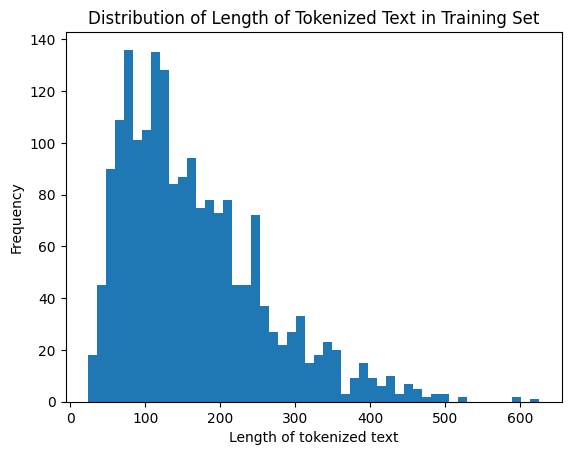

In [22]:
plt.hist(lengths, bins=50)
plt.xlabel('Length of tokenized text')
plt.ylabel('Frequency')
plt.title('Distribution of Length of Tokenized Text in Training Set')
plt.show()

In [23]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
from sklearn.metrics import f1_score, classification_report

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)

    # Overall macro and weighted F1
    macro_f1 = f1_score(labels, preds, average='macro')
    weighted_f1 = f1_score(labels, preds, average='weighted')

    # Per-class F1
    per_class_f1 = f1_score(labels, preds, average=None)

    # Optionally: readable class report for debugging (not returned to Trainer)
    # print(classification_report(labels, preds))

    # Return metrics (names must be unique)
    metrics = {
        "f1_macro": macro_f1
    }

    # Add per-class F1s with names like f1_class_0, f1_class_1, etc.
    for i, score in enumerate(per_class_f1):
        metrics[f"f1_class_{i}"] = score

    return metrics

In [25]:
labels = [
    '(1) S: action',
    '(3) S: intermediate outcome',
    '(5) B: output',
    '(7) B: outcome'
]

id2label = {idx: label for idx, label in enumerate(labels)}
label2id = {label: idx for idx, label in enumerate(labels)}

In [26]:
id2label

{0: '(1) S: action',
 1: '(3) S: intermediate outcome',
 2: '(5) B: output',
 3: '(7) B: outcome'}

In [27]:
label2id

{'(1) S: action': 0,
 '(3) S: intermediate outcome': 1,
 '(5) B: output': 2,
 '(7) B: outcome': 3}

In [28]:
def convert_labels(example):
    example["labels"] = label2id[example["labels"]]
    return example

In [29]:
tokenized = tokenized.map(convert_labels)

Map:   0%|          | 0/1900 [00:00<?, ? examples/s]

Map:   0%|          | 0/594 [00:00<?, ? examples/s]

In [30]:
train_labels = tokenized['train']['labels']


In [31]:
tokenized

DatasetDict({
    train: Dataset({
        features: ['combined_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1900
    })
    eval: Dataset({
        features: ['combined_text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 594
    })
})

In [32]:
len(train_labels)

1900

what does "balanced" mean

The key insight is that the weights are normalized so that:
```
Σ (weight[i] * count[i]) = n_samples
This means the total weighted contribution across all classes equals the total sample size. Each class contributes equally to the loss on average, which effectively balances the dataset.

In [61]:
"""from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)"""

In [62]:
"""class_weights"""

array([0.54347826, 1.13636364, 2.31707317, 1.17866005])

In [63]:
"""import torch"""

In [64]:
# Convert to PyTorch tensor (don't move to device yet - let the Trainer handle it)
"""class_weights = torch.tensor(class_weights, dtype=torch.float)"""

In [65]:
"""from transformers import Trainer

# Custom Trainer
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss"""


In [157]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [158]:
16*8

128

In [159]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="models/distilbert-bs16-lr2e5-15epochs-gradaccum8",  # <-- save checkpoints here
     learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=8,
    fp16=True,
    num_train_epochs=15,  # Usually 3-4 is better than 2
    weight_decay=0.01,
    eval_strategy="steps",
    eval_steps=15,  #  1900 obs and batch size 16, 1900/16=119 steps per epoch, so to evaluate twicec per epoch 119/2=60
    save_strategy="steps",
    save_total_limit=2,
    save_steps=15, # Only keep 2 best checkpoints
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",  # Important!
    greater_is_better=True,  # F1 should be maximized
    logging_steps=5,  # Log every 50 steps
    logging_strategy="steps",
    report_to="wandb",  # Enable W&B logging
    push_to_hub=False,
    run_name="distilbert-bs16-lr2e5-15epochs-gradaccum8",  # Optional: custom run name
)

In [160]:
import wandb


In [94]:
from google.colab import userdata


In [44]:
# use wandb token from secrets
wandb.login(key=userdata.get('WANDB'))

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ds_duo to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [161]:
from transformers import EarlyStoppingCallback

In [162]:

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["eval"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]

)

In [163]:
trainer.train()

Step,Training Loss,Validation Loss,F1 Macro,F1 Class 0,F1 Class 1,F1 Class 2,F1 Class 3
15,1.166300,1.189903,0.148521,0.594083,0.000000,0.000000,0.000000
30,1.002800,0.955034,0.490320,0.773973,0.497653,0.000000,0.689655
45,0.789100,0.777803,0.691811,0.821622,0.560000,0.568627,0.816993
60,0.613400,0.649153,0.726531,0.844765,0.626168,0.598131,0.837061
75,0.494900,0.534670,0.794052,0.875486,0.728000,0.701754,0.870968
90,0.390900,0.459758,0.851436,0.891945,0.764479,0.834646,0.914676
105,0.295300,0.424311,0.851915,0.895050,0.769231,0.828125,0.915254
120,0.272800,0.400092,0.871566,0.909449,0.793774,0.861538,0.921502
135,0.238800,0.381703,0.872079,0.900000,0.787879,0.859259,0.941176
150,0.185400,0.369064,0.882100,0.912351,0.809160,0.872180,0.934708


TrainOutput(global_step=225, training_loss=0.4377144336700439, metrics={'train_runtime': 484.6778, 'train_samples_per_second': 58.802, 'train_steps_per_second': 0.464, 'total_flos': 3775455516672000.0, 'train_loss': 0.4377144336700439, 'epoch': 15.0})

In [137]:
wandb.finish()  # closes current run

eval/f1_class_0,▁▃▅▆▇▇▇▇▇▇████████████
eval/f1_class_1,▁▂▅▆▇▇▇▇▇▇████████████
eval/f1_class_2,▁▁▅▅▆▇▇▇█▇████████████
eval/f1_class_3,▁▆▇▇▇█████████████████
eval/f1_macro,▁▃▆▆▇▇▇███████████████
eval/loss,█▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁█▂▄▁▁▂▂▃▄▁▂▅▂▃▂▂▃▁▂▂▂
eval/samples_per_second,█▁▇▅█▇▇▇▆▄▇▇▄▇▆▇▇▅█▇▇▇
eval/steps_per_second,█▁▇▅█▇▇▇▆▄▇▇▄▇▆▇▇▅█▇▇▇
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
+4,...


In [164]:
! ls models/distilbert-bs16-lr2e5-15epochs-gradaccum8

checkpoint-210	checkpoint-225


# Prediction and evaluation

In [165]:
# load data
import pandas
df = pd.read_csv("data/processed/PforR_PDODLR_database_train_test.csv")

In [166]:
test = df[df['data_split']=="test"]

In [167]:
len(test)

594

In [168]:
test.dlr_rcp_max_4.value_counts(dropna=False)

,count
dlr_rcp_max_4,
(1) S: action,251
(7) B: outcome,141
(3) S: intermediate outcome,130
(5) B: output,72


In [169]:
#load best model
model_dir = "models/distilbert-bs16-lr2e5-15epochs-gradaccum8/checkpoint-210"

from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_dir)

In [170]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [171]:
inputs = tokenizer(
    df["combined_text"].tolist(),
    padding="max_length",
    truncation=True,
    max_length=512,
    return_tensors="pt"
)

In [172]:
batch_size = 16  # try changing depending on VRAM

In [173]:
texts = test["combined_text"].tolist()

In [174]:
import torch

In [175]:
all_preds = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [176]:
from tqdm import tqdm

In [177]:
for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]

    inputs = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.softmax(outputs.logits, dim=1)
    preds = torch.argmax(probs, dim=1).tolist()
    all_preds.extend(preds)

test["predictions"] = all_preds

100%|██████████| 38/38 [00:01<00:00, 23.20it/s]
/tmp/ipython-input-3411131775.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = all_preds


In [178]:
test['predictions'].head()

,predictions
15,0
21,1
25,1
33,0
43,2


In [179]:
test['predictions_labels']= test['predictions'].apply(lambda x: id2label[x])

/tmp/ipython-input-1175414480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['predictions_labels']= test['predictions'].apply(lambda x: id2label[x])


In [180]:
# import cllassification report

from sklearn.metrics import classification_report

report = classification_report(test['dlr_rcp_max_4'], test['predictions_labels'])

In [181]:
print(report) # bs128 is worse than 64


                             precision    recall  f1-score   support

              (1) S: action       0.92      0.90      0.91       251
(3) S: intermediate outcome       0.82      0.84      0.83       130
              (5) B: output       0.91      0.85      0.88        72
             (7) B: outcome       0.93      0.96      0.94       141

                   accuracy                           0.90       594
                  macro avg       0.89      0.89      0.89       594
               weighted avg       0.90      0.90      0.90       594



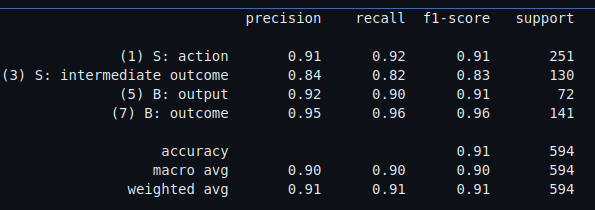